<a href="https://colab.research.google.com/github/papachristoumarios/core-periphery-latent-model/blob/main/Continuous_Infulencer_Guided_Attachment_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install hypernetx --quiet
!pip install pystan --quiet
!pip install arviz --quiet
!git clone https://github.com/zhengdao-chen/GNN4CD --quiet

In [2]:
import scipy.io
import os
import copy
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numpy as np
import networkx as nx
import collections
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import pandas as pd
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive/')
import random
import itertools
import pystan
import arviz as az
sns.set_theme()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Hypergraph Model

In [3]:
def load_world_trade(location='/content/drive/My Drive/NNIM/data/world-trade/world-trade.csv'):
  df = pd.read_csv(location)
  G = nx.convert_matrix.from_pandas_edgelist(df, source='from', target='to')
  return G

def load_faculty(location='/content/drive/My Drive/NNIM/data/faculty/ComputerScience_edgelist.txt'):
  df = pd.read_csv(location, sep='\t')
  G = nx.convert_matrix.from_pandas_edgelist(df, source='# u', target='v')
  vertexlist_filename = location.replace('edgelist', 'vertexlist')
  vertex_df = pd.read_csv(vertexlist_filename, sep='\t')
  vertex_df.set_index('# u', inplace=True)
  mapping = vertex_df['institution'].to_dict()
  nx.set_node_attributes(G, mapping, 'name')

  return G

def load_polblogs(location='/content/drive/My Drive/NNIM/data/polblogs/polblogs.mtx'):
  df = pd.read_csv(location, sep=' ', comment='%', header=None)
  G = nx.convert_matrix.from_pandas_edgelist(df, source=0, target=1)
  return G

def load_airports(location='/content/drive/My Drive/NNIM/data/airports/USairport500.txt'):
  df = pd.read_csv(location, sep=' ', header=None)
  G = nx.convert_matrix.from_pandas_edgelist(df, source=0, target=1)
  return G

def load_celegans(location='/content/drive/My Drive/NNIM/data/celegans', relabel=True):
  A = np.genfromtxt(os.path.join(location, 'celegans_matrix.csv'), delimiter=',', dtype=np.int64).astype(np.int64)
  locs = np.genfromtxt(os.path.join(location, 'celegans_positions.csv'), delimiter=',').astype(np.float64)
  mapping = {}
  for i, loc in enumerate(locs):
    mapping[i] = loc

  G = nx.from_numpy_array(A)

  Gccs = sorted(nx.connected_components(G), key=len, reverse=True)
  G = G.subgraph(Gccs[0])

  nx.set_node_attributes(G, mapping, "location")

  if relabel:
    G = nx.convert_node_labels_to_integers(G)

  return G

def load_london_underground(location='/content/drive/My Drive/NNIM/data/london_underground', relabel=True):
  A = np.genfromtxt(os.path.join(location, 'london_underground_network.csv'), delimiter=',', dtype=np.int64).astype(np.int64)
  locs = np.genfromtxt(os.path.join(location, 'london_underground_tubes.csv'), delimiter=',').astype(np.float64)
  names = np.genfromtxt(os.path.join(location, 'london_underground_names.csv'), delimiter='\t', dtype=str)

  mapping = {}
  for i, loc in enumerate(locs):
    mapping[i] = loc

  names_mapping = {}
  for i, name in enumerate(names):
    names_mapping[i] = name

  G = nx.from_numpy_array(A)

  Gccs = sorted(nx.connected_components(G), key=len, reverse=True)
  G = G.subgraph(Gccs[0])

  nx.set_node_attributes(G, mapping, "location")
  nx.set_node_attributes(G, names_mapping, "name")

  if relabel:
    G = nx.convert_node_labels_to_integers(G)

  return G

def load_open_airlines(location='/content/drive/My Drive/NNIM/data/open_airlines', relabel=True):
  airports = pd.read_csv(os.path.join(location, 'airports.dat'), header=None).iloc[:, [4, 6, 7]]
  routes = pd.read_csv(os.path.join(location, 'routes.dat'), header=None).iloc[:, [2, 4]]
  G = nx.convert_matrix.from_pandas_edgelist(routes, source=2, target=4, create_using=nx.Graph)
  Gccs = sorted(nx.connected_components(G), key=len, reverse=True)
  G = G.subgraph(Gccs[0])
  mapping = {}
  for i, x in airports.iterrows():
    if G.has_node(x[4]):
      mapping[x[4]] = np.array([x[6], x[7]])

  nx.set_node_attributes(G, mapping, "location")

  if relabel:
    G = nx.convert_node_labels_to_integers(G, label_attribute='name')

  return G  

def load_fungal(location='/content/drive/My Drive/NNIM/data/fungal_networks', fungus='Pv_M_I_U_N_42d_1.mat', relabel=True):
  mat = scipy.io.loadmat(os.path.join(location, fungus))
  G = nx.from_scipy_sparse_matrix(mat['A'], create_using=nx.Graph)
  mapping = {}

  for i in range(mat['coordinates'].shape[0]):
      mapping[i] = mat['coordinates'][i]

  nx.set_node_attributes(G, mapping, 'location')  
  if relabel:
    G = nx.convert_node_labels_to_integers(G)

  return G

class Simplex:

  def __init__(self, nodes=[], timestamp=None):
    self.nodes = nodes
    self.timestamp = timestamp

  def __len__(self):
    return len(nodes)

  def add_node(self, node):
    self.nodes.append(node)

class Hypergraph:

  def __init__(self):
    self.nodes = collections.defaultdict(bool)
    self.simplices = []
    self.pointers = collections.defaultdict(list)
    self.graph = nx.Graph()

  def add_simplex(self, simplex):
    self.simplices.append(simplex)
    for node in simplex.nodes:
      self.nodes[node] = True
      self.pointers[node].append(len(self.simplices) - 1)
    
    for u in simplex.nodes:
      for v in simplex.nodes:
        if u != v:
          self.graph.add_edge(u, v, timestamp=simplex.timestamp)

  def simplex_neighbors(self, node):
    for pointer in self.pointers[node]:
      yield self.simplices[pointer]

  def nodes(self):
    for key in self.nodes:
      yield key

  def simplices_iter(self):
    for simplex in self.simplices:
      yield simplex

  def __len__(self):
    return len(self.nodes)
  
  def num_simplices(self):
    return len(self.simplices)

  @staticmethod
  def graph_to_hypergraph(G):
    H = Hypergraph()
    for (u, v) in G.edges():
      smp = Simplex([u, v])
      H.add_simplex(smp)

    return H

def load_hypergraph(name='email-Enron', location='/content/drive/My Drive/NNIM/data'):
  nverts = np.genfromtxt(os.path.join(location, name, '{}-nverts.txt'.format(name)), delimiter=',', dtype=np.int64)
  simplices = np.genfromtxt(os.path.join(location, name, '{}-simplices.txt'.format(name)), delimiter=',', dtype=np.int64)
  times = np.genfromtxt(os.path.join(location, name, '{}-times.txt'.format(name)), delimiter=',', dtype=np.int64)

  H = Hypergraph()
  j = 0

  for nvert, timestamp in zip(nverts, times):
    simplex = Simplex([], timestamp)
    for i in range(nvert):
      simplex.add_node(simplices[j])
      j += 1
      
    H.add_simplex(simplex)    

  return H

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9aaabfba2aa7ea8dddf74d2460d1f770 NOW.


KeyError: ignored

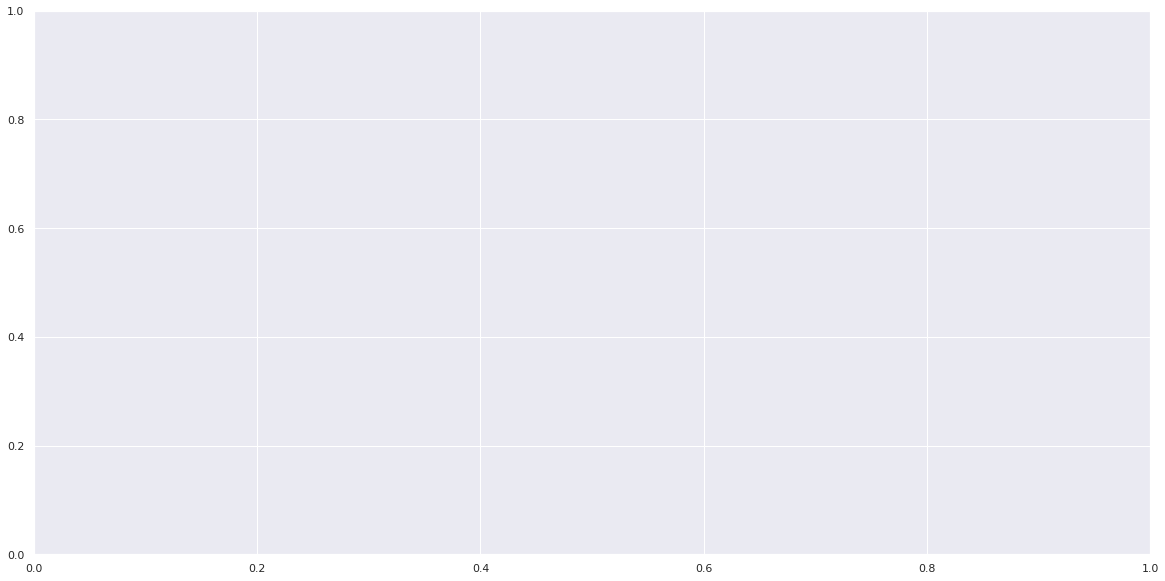

In [5]:


def mns(H, s):
  u0, v0 = random.choice(list(H.graph.edges())) 
  f = set([u0, v0])

  while len(f) < s:
    S = set([])
    for u in f:
      for v in H.graph.neighbors(u):
        S |= {(u, v)}

    if len(S) == 0:
      return mns(H, s)
    else:
      u, v = random.choice(list(S))
      f |= {u, v}

  return f

def cns(H, s):
  f = set(random.choice(H.simplices).nodes)
  v = random.choice(list(f))
  
  while len(f) < s:
    V = set([])
    for u in f - {v}:
      for smp in H.simplex_neighbors(u):
        for w in smp.nodes:  
          V |= {w}

    if len(V) == 0:
      return cns(H, s)
    else:
      v1 = random.choice(list(V))
      f = (f - {v}) | {v1}
  return f

# Sample heights based on the inverse transform
def continuous_tree_sample(b, H, shape=1):
  u = np.random.uniform(size=shape)
  y = np.log(u * (b**H - 1) + 1) / np.log(b) 
  return y

# Directly sample discrete heights
def discrete_tree_sample(b, H, shape=1):
  weights = [b**h for h in range(H)]
  choices = list(range(H))
  return np.array(random.choices(choices, weights, k=shape))

# Sample continuous IGAM
def sample_igam(c1, c2, b, H, H0, continuous=True):
  assert(b > 1)
  assert(1 < c1 < b)
  n = b**H - 1
  G = nx.Graph()

  if continuous:
    h = continuous_tree_sample(b, H, shape=n)
  else:
    h = discrete_tree_sample(b, H, shape=n)

  h = np.sort(h)

  for u in range(n):
    for v in range(u):
      if u != v and max(h[u], h[v]) <= H0 and np.random.uniform() <= c1**(-1-min(h[u], h[v])):
        G.add_edge(u, v)
      if u != v and max(h[u], h[v]) > H0 and np.random.uniform() <= c2**(-1-min(h[u], h[v])):
        G.add_edge(u, v)

  return G, h
 
def continuous_igam_stan_model(c, b, H):

  G, h = sample_igam(c, c, b, H, 0, continuous=True)

  model_code = '''
    data {
      int N;
      real H;
      int<lower=0, upper=1> A[N, N];
      real<lower=0, upper=H> heights[N];
    }

    transformed data {
      real<lower=0, upper=H> ranks[N];
      for (i in 1:N) {
        ranks[i] = H - heights[i];
      }
    }

    parameters {
      real<lower=0> lambda;
      real<lower=1> c;
    }

    model {
      lambda ~ gamma(2, 2);

      for (i in 1:N) {
        ranks[i] ~ exponential(lambda);
      }

      for (i in 1:N) {
        for (j in 1:N) {
          if (heights[i] <= heights[j]) A[i, j] ~ bernoulli(pow(c, -1-heights[i]));
          else A[i, j] ~ bernoulli(pow(c, -1-heights[j]));
        }
      }
    }

  '''

  stan_model = pystan.StanModel(model_code=model_code)


  model_data = {
      'N' : len(G),
      'H' : H,
      'A' : nx.to_numpy_array(G).astype(np.int64),
      'heights' : h
  }


  fit = stan_model.sampling(data=model_data, iter=1000, chains=4, seed=1)

  fig, ax = plt.subplots(figsize=(20, 10))
  sns.histplot(fit.extract()['c'], kde=True, label='$c$', ax=ax, color='r')
  sns.histplot(fit.extract()['lambda'], kde=True, label='$\lambda$', ax=ax, color='g')
  sns.histplot(np.exp(fit.extract()['lambda']), kde=True, label='$b$', ax=ax, color='b')
  plt.xlabel('Parameters')
  plt.ylabel('Posterior')
  plt.legend()

  # import pdb; pdb.set_trace()

def fit_cigam(H):

  



posterior_heights(1.5, 3, 5)